# Demonstration Informed Specification Search: Experiment

Let's take a look at how the DISS algorithm can search for specifications by leveraging expert demonstrations. 
We'll focus on learning DFAs in this case, but note that this approach is not confined to any specific concept class.

In [1]:
import funcy as fn
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict
from IPython.display import Image, display
import networkx as nx
import pydot

from collections import Counter

import dfa
import funcy as fn
from dfa.utils import find_subset_counterexample
from dfa_identify import find_dfa

from diss.product_mc import ProductMC
from diss.dfa_concept import DFAConcept
from diss.domains.gridworld_naive import GridWorldNaive as World
from diss.domains.gridworld_naive import GridWorldState as State
from diss import search, LabeledExamples, GradientGuidedSampler

Let's first visualize our gridworld and a demonstration within the gridworld.

In [15]:
from IPython.display import HTML as html_print


COLOR_ALIAS = {
    'yellow': '#ffff00', 'brown': '#ffb081',
    'red': '#ff8b8b', 'blue': '#afafff', 'green' : '#67f7a1'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, world):
    """Use sensor to create colored tile."""
    if (x, y) in world.overlay:
        color = world.overlay[(x,y)]

        if color in COLOR_ALIAS.keys():
            return tile(color)
    return tile('white')

def print_map(world):
    """Scan the board row by row and print colored tiles."""
    order = range(1, world.dim + 1)
    for y in order:
        chars = (ap_at_state(x, y, world) for x in order)
        display(html_print('&nbsp;'.join(chars)))
        
def print_trc(trc, idx=0):
    actions, states = trc
    obs = (ap_at_state(*pos, in_ascii=True) for pos in states)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )
        

In [16]:
gw = World(
    dim=3,
    start=State(x=3, y=1),
    overlay={
      (1, 1): 'yellow',
      (1, 2): 'green',
      (1, 3): 'green',
      (2, 3): 'red',
      (3, 2): 'blue',
      (3, 3): 'blue',
    }
)

print()
state = gw.start
#print(gw.to_string(state))
assert gw.player(state) == 'ego'
assert len(gw.moves(state)) == 2

move_hist = Counter(len(gw.moves(m)) for m in gw.moves(state))
assert move_hist == {1: 1, 2: 1}
assert all(gw.player(m) == 'env' for m in gw.moves(state))

state = State(x=2, y=2)
assert gw.player(state) == 'ego'
assert len(gw.moves(state)) == 4

demos = [[
   (State(3, 1), 'ego'),
   (State(3, 1, '←'), 'env'),
   (State(3, 2), 'ego'),
   (State(3, 2, '←'), 'env'),
   (State(2, 2), 'ego'),
   (State(2, 2, '←'), 'env'),
   (State(1, 2), 'ego'),
   (State(1, 2, '↑'), 'env'),
   (State(1, 1), 'ego'),
]]
#print(gw.to_string(state))
print_map(gw)

Now, we can define a set of expert demonstrations for this gridworld to guide our specification search procedure.

In [17]:
gw = World(
    dim=3,
    start=State(x=3, y=1),
    overlay={
      (1, 1): 'yellow',
      (1, 2): 'green',
      (1, 3): 'green',
      (2, 3): 'red',
      (3, 2): 'blue',
      (3, 3): 'blue',
    }
)

print()
state = gw.start
assert gw.player(state) == 'ego'
assert len(gw.moves(state)) == 2

move_hist = Counter(len(gw.moves(m)) for m in gw.moves(state))
assert move_hist == {1: 1, 2: 1}
assert all(gw.player(m) == 'env' for m in gw.moves(state))

state = State(x=2, y=2)
assert gw.player(state) == 'ego'
assert len(gw.moves(state)) == 4

demos = [[
   (State(3, 1), 'ego'),
   (State(3, 1, '←'), 'env'),
   (State(3, 2), 'ego'),
   (State(3, 2, '←'), 'env'),
   (State(2, 2), 'ego'),
   (State(2, 2, '←'), 'env'),
   (State(1, 2), 'ego'),
   (State(1, 2, '↑'), 'env'),
   (State(1, 1), 'ego'),
]]


Let's start with some very simple base examples to warm-start our specification search process. We want to synthesize a spec that's consistent with the observed evidence thus far:

In [18]:

def sampler_factory(demos):
    return GradientGuidedSampler.from_demos(
        demos=demos,
        to_chain=lambda c, t: ProductMC.construct(
            concept=c, tree=t, dyn=gw, max_depth=9, psat=0.8
        ),
    )

base_examples = LabeledExamples(
    positive=[
        ('yellow',),
        ('yellow', 'yellow'),
        #('blue', 'green', 'yellow'), # Demo
    ],
    negative=[
        (), ('red',), ('red', 'red'),
        ('red', 'yellow'), ('yellow', 'red'),
        ('yellow', 'red', 'yellow'),
        ('yellow', 'yellow', 'red'),
    ]
)


Going from the partial spec to a full spec :

In [19]:

def partial_dfa(inputs):
    def transition(s, c):
        if s == 'dead' or c == 'red':
            return 'dead'
        elif s == 'wet' and c == 'yellow':
            return 'dead'
        elif s == 'wet' and c == 'green':
            return 'dry'
        elif s == 'dry' and c == 'yellow':
            return 'recharge'
        elif c == 'blue':
            return 'wet'
        return s

    return dfa.DFA(
        start='dry',
        inputs=inputs,
        label=lambda s: s == 'recharge',
        transition=transition
    )

def trace(path):
    return tuple(x for x in map(gw.sensor, path) if x != 'white')




Now, we can outline the machinery for the search process itself. We use the solution procedure in the DFA identification algorithm to synthesize a minimal DFA (in both states and non-stutterin edges) that is consistent with the observed examples to this point. 

In [24]:
def to_concept(data):
    data = LabeledExamples(
        positive = [trace(x) for x in data.positive],
        negative = [trace(x) for x in data.negative],
    )
    data @= base_examples

    # CEGIS for subset.
    for i in range(15):
        mydfa = find_dfa(data.positive, data.negative) 
        partial = partial_dfa(mydfa.inputs)
        ce = find_subset_counterexample(mydfa, partial)
        if ce is None:
            break
        data @= LabeledExamples(negative=[ce])

        partial = partial_dfa(mydfa.inputs)
        for k, lbl in enumerate(partial.transduce(ce)):
            prefix = ce[:k]
            if not lbl:
                data @= LabeledExamples(negative=[prefix])
            else:
                data @= LabeledExamples(positive=[prefix])

    return DFAConcept.from_examples(data, gw.sensor) 

dfa_search = search(demos, to_concept, sampler_factory)

data1, concept1 = next(dfa_search)
path1 = [x for x, _ in demos[0]]
assert path1 in concept1

data2, concept2 = next(dfa_search)
data3, concept3 = next(dfa_search)

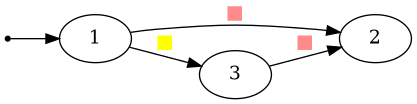

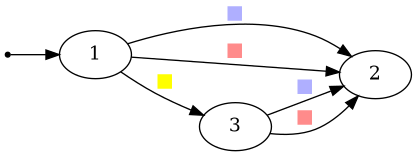

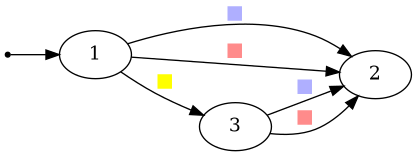

In [42]:
from diss.dfa_concept import remove_stutter
from collections import defaultdict

# adapted from the dfa library
def get_dot(dfa_):
    dfa_dict, init = dfa.dfa2dict(dfa_)
    remove_stutter(dfa_dict)
    
    nodes = {}
    for i, (k, (v, _)) in enumerate(dfa_dict.items()):
        shape = "doublecircle" if v else "circle"
        nodes[k] = pydot.Node(i+1, label=f"{k}", shape=shape)
    edges = defaultdict(list)
    for start, (_, transitions) in dfa_dict.items():        
        for action, end in transitions.items():
            color = COLOR_ALIAS[str(action)]
            edges[start, end].append(color)
    
    g = pydot.Dot(rankdir="LR")
    init_node = pydot.Node(0, shape="point", label="")
    g.add_node(init_node)
    g.add_edge(pydot.Edge(init_node, nodes[init]))

    for (start, end), colors in edges.items():
        for color in colors:
            g.add_edge(pydot.Edge(nodes[start], nodes[end], label='⬛', fontcolor=color))
            
    return g

def view_pydot(pdot):
    #pdot = nx.drawing.nx_pydot.to_pydot(pdot_graph)
    plt = Image(pdot.create_png())
    display(plt)

view_pydot(get_dot(concept1.dfa))
view_pydot(get_dot(concept2.dfa))
view_pydot(get_dot(concept3.dfa))
